In [13]:
import os
import glob
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

## 数据准备
### 方式一

In [2]:
files = glob.glob(os.path.join('../Desktop/201802/', '*.xlsx'))

datas = pd.DataFrame()
dates = []

for f in sorted(files):
    data = pd.read_excel(f, index_col=0)
    date = datetime.strptime(os.path.splitext(os.path.split(f)[1])[0], '%Y%m%d%H')
    dates.append([date]*data.shape[0]) # 确定每一个文件中有多少条目，创建多少个时间
    datas = datas.append(data)

datas.index = np.ravel(np.array(dates))

os.path.split   分离文件名称和文件后缀

os.path.splitext  分离路径和文件名

In [3]:
datas[['日期时间', '经度', '纬度', '风速', '风向']].head()

,日期时间,经度,纬度,风速,风向
2018-02-01,2.018020e+09,116.585472,35.414513,0.3,195.2
2018-02-01,2.018020e+09,116.585472,35.414513,0.3,195.2
2018-02-01,2.018020e+09,116.625526,35.429825,0.4,117.0
2018-02-01,2.018020e+09,116.625526,35.429825,0.4,117.0
2018-02-01,2.018020e+09,116.585472,35.414513,0.3,195.2


从上述输出的信息可以发现，其实原始数据中是包含时间信息的，这时候不需要根据文件名进行时间信息的处理，上面只是为了进行说明，进行了单独的处理。
原始数据的时间格式是: 2018020101，这种格式的时间转换方式一中已经提到了：datetime.strptime('2018020101', '%Y%m%d%H')

In [4]:
datetime.strptime('2018020101', '%Y%m%d%H')

datetime.datetime(2018, 2, 1, 1, 0)

### 注意：
防止数据缺失导致时间索引出现缺失，需要对处理后的数据进行重新索引

### 方式二

In [7]:
fp = r'../Desktop/201802/'

dates = pd.date_range(datetime(2018, 2, 1, 0), datetime(2018, 2, 28, 23), freq='1h')
fpfas = [os.path.join(fp, '%d%02d%02d%02d.xlsx'%(date.year, date.month, date.day, date.hour)) for date in dates]

alldata = pd.DataFrame()

for fpf in fpfas:
    try:
        data = pd.read_excel(fpf, index_col=0)
        alldata = alldata.append(data)
    except:
        print('%s 缺失.'%fpf)

../Desktop/201802/2018022620.xlsx 缺失.


### 站点分布

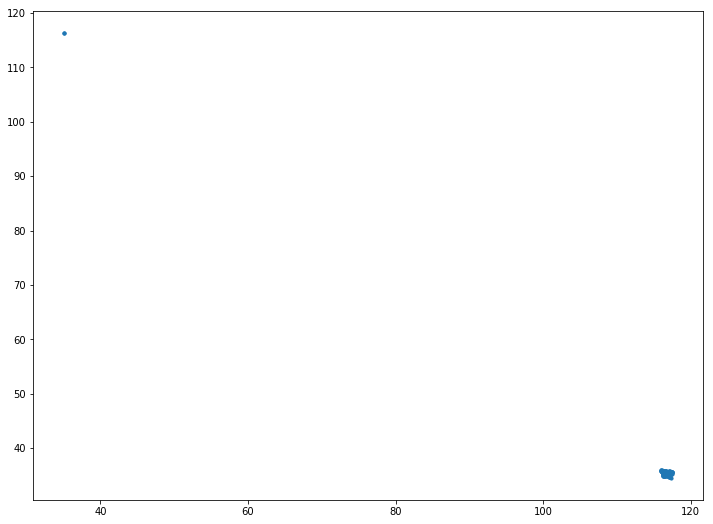

In [10]:
stas = alldata[['对应站点', '经度', '纬度']].drop_duplicates()

fig, ax = plt.subplots(figsize=(12, 9))

ax.scatter(stas['经度'], stas['纬度'], 10)

### 检查站点是否存在位置迁移

In [11]:
def check_unique(data, cond, column):
    '''检查唯一性
    '''
    
    for con in cond:
        if data['经度'][data[column] == con].nunique() != 1 or data['纬度'][data[column] == con].nunique() != 1:
            print('请检查 %s %s.'%(column, con))    

In [12]:
alldata = alldata[~alldata['所属乡镇'].isin(alldata[alldata['对应站点'].isnull()]['所属乡镇'].unique())]

alldata = alldata[['日期时间', '对应站点', '经度', '纬度', '风速', '风向']]

alldata.drop_duplicates(inplace=True)

stations = alldata['对应站点'].unique()
## 检查所有站点经纬度坐标是否一致，如果不一致是明显错误还是站点迁移
check_unique(alldata, stations, '对应站点')  

运行结束之后没有输出任何信息，表明所有站点没有迁移记录

### 风速和风向值分布

In [15]:
spds = alldata[['日期时间', '风速']]
dirs = alldata[['日期时间', '风向']]

spds = spds.dropna()
dirs = dirs.dropna()

spds['日期时间'] = spds['日期时间'].astype(np.int).astype(np.str_)
spds['日期时间'] = pd.to_datetime(spds['日期时间'], format='%Y%m%d%H')

dirs['日期时间'] = dirs['日期时间'].astype(np.int).astype(np.str_)
dirs['日期时间'] = pd.to_datetime(dirs['日期时间'], format='%Y%m%d%H')

spds.index = spds['日期时间']
dirs.index = dirs['日期时间']

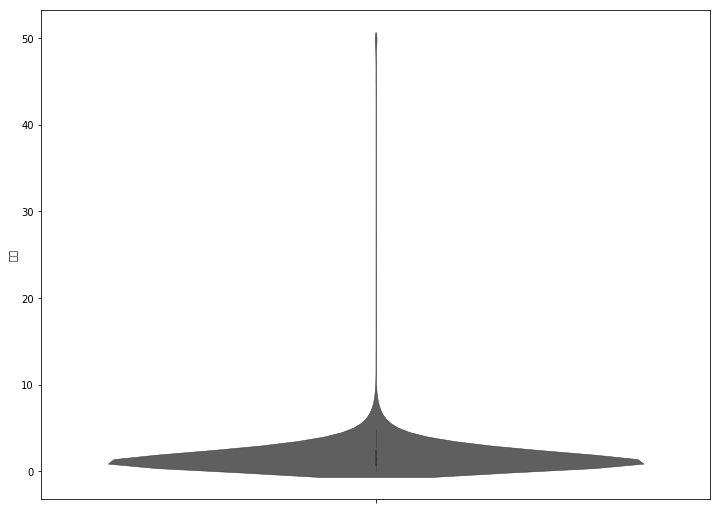

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))

sns.violinplot(data=spds, y='风速', color='#5f5f5f', bw=.2, cut=1, linewidth=.5, ax=ax)

fig.savefig('spds_boxplot.png', dpi=600, bbox_inches='tight')

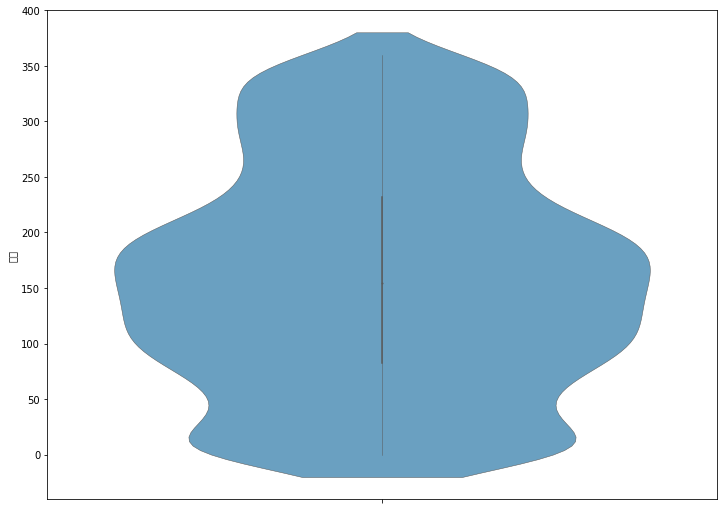

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))

sns.violinplot(data=dirs, y='风向', color='#5ba3d0', bw=.2, cut=1, linewidth=.5, ax=ax)

fig.savefig('dirs_boxplot.png', dpi=600, bbox_inches='tight')

In [ ]:
subd = pd.DataFrame(index=stations, columns=['经度', '纬度', '缺失值个数'])
for i in stations:
    subd['经度'][i] = alldata[alldata['对应站点'] == i]['经度'].unique()[0]
    subd['纬度'][i] = alldata[alldata['对应站点'] == i]['纬度'].unique()[0]
    subd['缺失值个数'][i] = alldata[alldata['对应站点'] == i]['风速'].isnull().sum()
    print('%s 共有 %d 个缺失值.'%(i, alldata[alldata['对应站点'] == i]['风速'].isnull().sum()))

In [ ]:
subd2 = subd.sort_values(by='缺失值个数', ascending=False)

fig, ax = plt.subplots(figsize=(30, 6))

subd2.plot(ax=ax)

ax.set_xlim([-2, subd2.shape[0]])

ax.set_xticks(np.arange(subd2.shape[0]))
ax.set_xticklabels(subd2.index.values, fontdict=dict(fontsize=10), rotation=90)

fig.savefig('各站点风速缺失值情况.png', dpi=600, bbox_inches='tight')

检查了风向和风速的值分布情况之后，需要检查各站点风向和风速数据的缺失情况，为了更为直观可以绘图查看，有时候根据不同的需要可能需要绘制单站时间序列形式的数据缺失情况，这个需要针对不同的分析要求进行处理

In [19]:
def check_outlier(data, stations, columns, values):
    '''检查异常值
    
    参数说明
        data : 需要进行异常值检查的数据
        stations : 站点名称
        columns : 需要检查的列
        values : 对应列的阈值，超出阈值即为异常
    '''
    
    for col, value in zip(columns, values):
        print('开始验证 %s: '%col)
        for sta in stations:
            try:
                print('当前站点: %s.'%sta)
                subs = data[data['对应站点'] == sta][col].reindex(dates)
                diff = subs.diff().abs() > value

                print('以下是可能出现的异常数据:')
                print(subs[diff])
                print('-------------------------------------')
            except:
                print('检查站点: %s 时出现问题.'%sta)

这是一个简单的风速异常值检测方法，简单的检查相邻两个时刻风速差值的绝对值，如果绝对值大于某一个阈值就认为风速异常，这种情况对于时间分辨率比较高且数据缺失不是很多的情况，如果数据缺失较多或者时间分辨率很低，则不适合使用这种方法进行检测

比如将阈值设为15 m/s，如果相邻两个时刻的风速差绝对值大于15 m/s，则认为风速异常。

In [ ]:
check_outlier(alldata, stations, ['风速'], [15])